In [1]:
import fair 

In [2]:
import numpy as np
from scipy import stats
from scipy import signal
import pandas as pd
from matplotlib import pyplot as plt


In [3]:
from scipy import stats
from fair.tools.ensemble import tcrecs_generate
from fair.forward import fair_scm

In [4]:
from functions import *

In [5]:
fair._version.get_versions()['version']

'1.6.4'

In [6]:
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen

from fair.tools.constrain import hist_temp


In [7]:
from fair.RCPs import rcp3pd, rcp45, rcp6, rcp85
from fair.SSPs import ssp370, ssp126, ssp585, ssp119,ssp245,ssp534, ssp460

In [8]:
samples=400

In [9]:
pmat0=make_params(n=samples)

In [10]:
if 0:
    Ce, Fe, Te=run_fair(pmat0,ssp585.Emissions.emissions)

    # load up Cowtan and Way data remotely
    url = 'http://www-users.york.ac.uk/~kdc3/papers/coverage2013/had4_krig_annual_v2_0_0.txt'
    response = urlopen(url)

    CW = np.loadtxt(response)
    constrained = np.zeros(samples, dtype=bool)

    for i in range(samples):
        # we use observed trend from 1880 to 2016
        constrained[i], _, _, _, _ = hist_temp(CW[30:167,1], Te[1880-1765:2017-1765,i], CW[30:167,0])

    # How many ensemble members passed the constraint?
    print('%d ensemble members passed historical constraint' % np.sum(constrained))
    pmat=pmat0.iloc[constrained]
    pmat.to_json('params.json')
else:
    pmat=pd.read_json('params.json')
    

In [11]:
yr=ssp119.Emissions.year

In [12]:
pmat

,tcrecs,F_scale,r0,rc,rt
2,"[1.9164315474, 3.3325063205]","[0.9256881635, 1.1958813511, 0.8499423713, 1.0...",28.802228,0.018276,3.591255
6,"[1.4952208442000001, 2.7864763932]","[0.9480018396000001, 1.150789782, 1.0473977717...",32.744970,0.019479,3.550394
12,"[2.2478102446, 3.6239711846000002]","[0.8294102976000001, 0.8000895226, 1.184822691...",28.947219,0.017004,4.435995
13,"[1.353751828, 2.1302040038]","[1.0759746217, 0.8249525973, 1.0065879024, 1.0...",32.652741,0.018984,4.217292
22,"[1.4892220521, 2.9603337233]","[0.9771125634000001, 1.2066151109, 0.986035402...",35.289613,0.018902,4.230447
...,...,...,...,...,...
383,"[1.7605096894, 3.1112321302]","[0.7559715868, 0.8497043556, 0.994059282, 0.95...",34.326625,0.019547,3.934890
385,"[2.0448528246, 3.2815409123]","[1.1858380468, 0.9933317448000001, 1.000494438...",37.476038,0.020849,4.152863
386,"[1.6305477746, 2.303302437]","[1.0696320707, 1.1183534061, 0.964117113, 1.08...",34.415892,0.019882,5.082646
388,"[1.9699720242, 3.4414167043]","[0.9819900751, 1.1684880905, 0.9623914885, 1.2...",35.942175,0.021161,3.742962


In [13]:
np.array(pmat['F_scale']).shape

(119,)

In [14]:
import copy

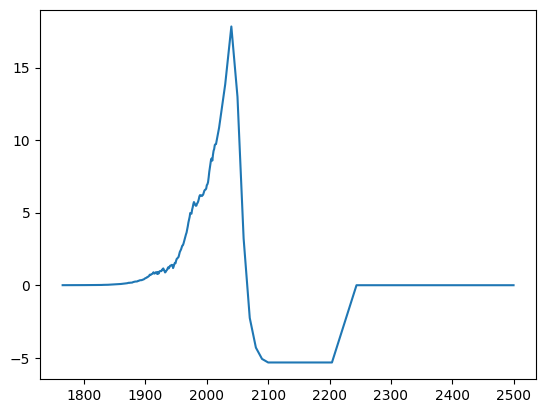

In [15]:
ssp3ext=copy.deepcopy(ssp534)
ssp3ext.Emissions.emissions[340:,1]=ssp3ext.Emissions.emissions[340,1]
ssp3ext.Emissions.emissions[440:480,1]=ssp3ext.Emissions.emissions[340,1]*(1-np.arange(1,41,1)/40)
ssp3ext.Emissions.emissions[480:,1]=0

plt.plot(ssp3ext.Emissions.emissions[:,0],ssp3ext.Emissions.emissions[:,1])


Example of stochastic failure model

Text(0.5, 0, 'Years')

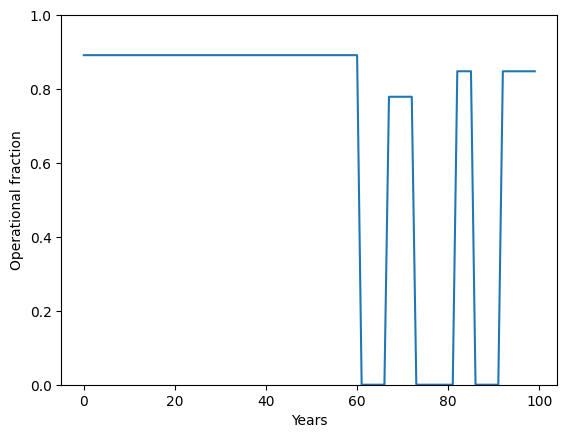

In [16]:
# Example usage
prob_failure = 0.05
avg_outage_length = 5
total_years = 100
failure_sequence,fracfail = simulate_failure(prob_failure, avg_outage_length, total_years,0.2)
plt.plot(1-fracfail)
plt.ylim([0,1])
plt.ylabel('Operational fraction')
plt.xlabel('Years')

In [17]:
d = {'name':['SRMPa','SRMPb','SRMPc','SRMPd','SRMPe'],
     'Start': [2040,2040,2040,2040,2040], 
     'End': [2170,2170,2170,2170,2170], 
     'Effic': [.99,0.9,0.5,0.7,.99], 
     'fade':[20,10,5,10,20], 
     'mhaz':[0,.4,.8,.4,.9], 
     'pfail':[0.0,0.008,0.03,0.015,0.008], 
     'aol':[0,10,10,10,10],
     'maxsrm':[2.0,4.0,4.0,4.0,8.0],
     'regionality':[0.1,.3,.5,0.8,.1]
     }
df = pd.DataFrame(data=d)
df


,name,Start,End,Effic,fade,mhaz,pfail,aol,maxsrm,regionality
0,SRMPa,2040,2170,0.99,20,0.0,0.000,0,2.0,0.1
1,SRMPb,2040,2170,0.90,10,0.4,0.008,10,4.0,0.3
2,SRMPc,2040,2170,0.50,5,0.8,0.030,10,4.0,0.5
3,SRMPd,2040,2170,0.70,10,0.4,0.015,10,4.0,0.8
4,SRMPe,2040,2170,0.99,20,0.9,0.008,10,8.0,0.1


In [18]:
sgn=np.array([-1,1,1,1,1])
(1-sgn)/2

array([1., 0., 0., 0., 0.])

In [19]:
from matplotlib import patches as mpatches

def arrow(self,x, y, dx, dy, **kwargs):
    kwargs.setdefault('arrowstyle', 'simple, head_width=10, head_length=10')
    kwargs.setdefault('fc', 'black')
    x = self.convert_xunits(x)
    y = self.convert_yunits(y)
    dx = self.convert_xunits(dx)
    dy = self.convert_yunits(dy)
    posA = x, y
    posB = x+dx, y+dy
    a = mpatches.FancyArrowPatch(posA=posA, posB=posB, **kwargs)
    self.add_artist(a)
    return a

<Figure size 1200x1000 with 0 Axes>

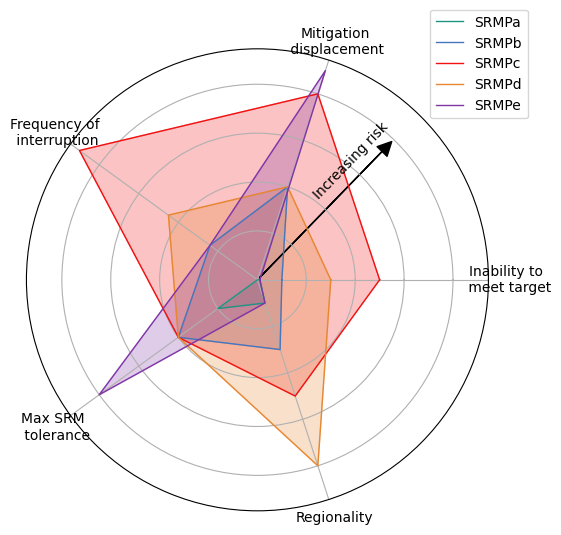

In [20]:
import numpy as np

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))

# Define the dimensions to plot
dimensions = ['Effic', 'mhaz', 'pfail', 'maxsrm', 'regionality']
dimlong=["Inability to \n meet target", 'Mitigation\n displacement', 'Frequency of\n interruption', 'Max SRM \n tolerance', 'Regionality']

# Number of variables
num_vars = len(dimensions)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
angles += angles[:1]
cols=['#1e9583','#4576be','#f11111','#e78731','#8036a7']
# Initialize the radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
scl=np.array([1,1,30,.1,1])
sgn=np.array([-1,1,1,1,1])
# Plot each row in the dataframe
for i, row in df.iloc[:].iterrows():
    values = ((1-sgn)/2+sgn*row[dimensions]*scl).tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row['name'],color=cols[i])
    ax.fill(angles, values, alpha=0.25,color=cols[i])

# Add labels to the chart
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dimlong)
arrow(ax,0, 0, .8, .8)
ax.text(40/180*np.pi,.5, 'Increasing risk', ha='center', va='bottom',rotation=46)
labels = []

for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    x,y = label.get_position()
    lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va())
    #lab.set_rotation(angle/np.pi*180)
    labels.append(lab)
# Add a legend
ax.set_xticklabels([])

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the plot
plt.show()

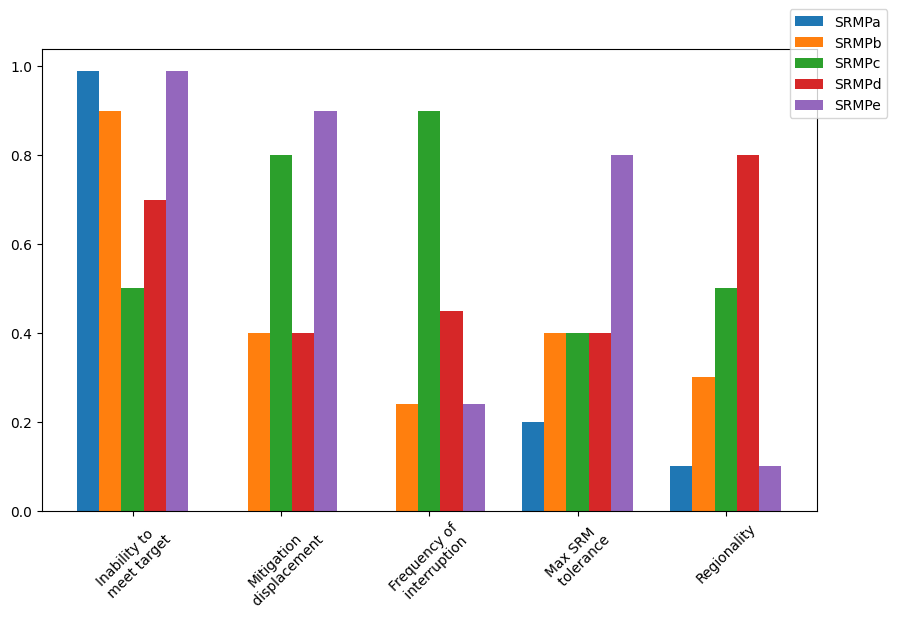

In [21]:

# Initialize the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Scaling factors
scl = np.array([1, 1, 30, .1, 1])

# Plot each row in the dataframe
bar_width = 0.15
for i, row in df.iterrows():
    values = (row[dimensions] * scl).tolist()
    bar_positions = np.arange(len(dimensions)) + i * bar_width
    ax.bar(bar_positions, values, bar_width, label=row['name'])

# Add labels to the chart
ax.set_xticks(np.arange(len(dimensions)) + bar_width * (len(df) - 1) / 2)
ax.set_xticklabels(dimlong)
plt.xticks(rotation = 45)
# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))


In [22]:
nt=len(ssp3ext.Emissions.emissions)

In [23]:
ems_bs=np.sum(ssp3ext.Emissions.emissions[:,1:3],axis=1)
Ce, Fe, T34 = run_fair(ssp3ext.Emissions.emissions,pmat0=None)

In [24]:
sspname=['ssp119','ssp245','ssp370','ssp460','ssp534','ssp585']
ssps=[ssp119,ssp245,ssp370,ssp460,ssp534,ssp585]
nssps=len(ssps)

In [25]:
len(pmat)

119

In [26]:
import time
import datetime as dt

def calcProcessTime(starttime, cur_iter, max_iter):

    telapsed = time.time() - starttime
    testimated = (telapsed/cur_iter)*(max_iter)

    finishtime = starttime + testimated
    finishtime = dt.datetime.fromtimestamp(finishtime).strftime("%H:%M:%S")  # in time

    lefttime = testimated-telapsed  # in seconds

    return (int(telapsed), int(lefttime), finishtime)

In [27]:
df

,name,Start,End,Effic,fade,mhaz,pfail,aol,maxsrm,regionality
0,SRMPa,2040,2170,0.99,20,0.0,0.000,0,2.0,0.1
1,SRMPb,2040,2170,0.90,10,0.4,0.008,10,4.0,0.3
2,SRMPc,2040,2170,0.50,5,0.8,0.030,10,4.0,0.5
3,SRMPd,2040,2170,0.70,10,0.4,0.015,10,4.0,0.8
4,SRMPe,2040,2170,0.99,20,0.9,0.008,10,8.0,0.1


In [28]:
C, F, T, srm, de,T0=adpt_fair(ssp126,5,1.5,df,i=2,p=pmat.iloc[[0]],iters=50)

[-0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

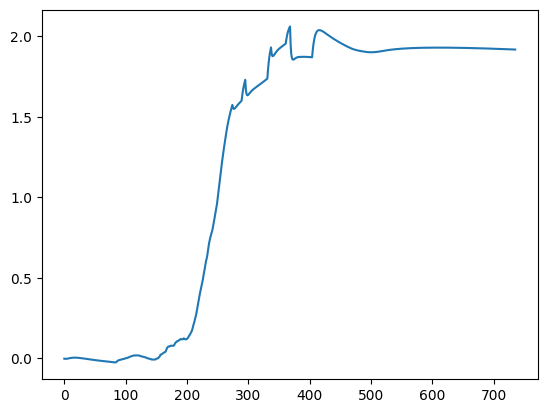

In [30]:
plt.plot(T)


In [31]:
import os
import numpy as np

In [33]:
if 1:
    nens=len(pmat[:])
    Cmat=np.zeros((nt,len(df),nens,nssps))
    Fmat=np.zeros((nt,len(df),nens,nssps))
    Tmat=np.zeros((nt,len(df),nens,nssps))
    srmmat=np.zeros((nt,len(df),nens,nssps))
    demat=np.zeros((nt,len(df),nens,nssps))
    T0mat=np.zeros((nt,len(df),nens,nssps))


    c=int(0)
    t0=time.time()
    for j in range(nens):
        
        for i,n in enumerate(df.name):
            for k,ssp in enumerate(ssps[:]):
                c=int(c+int(1))
                prstime = calcProcessTime(int(t0),c ,int(len(df)*nens*nssps))
                print_progress_bar(c, (len(df)*nens*nssps), prstime)
                Cmat[:,i,j,k], Fmat[:,i,j,k], Tmat[:,i,j,k], srmmat[:,i,j,k], demat[:,i,j,k],T0mat[:,i,j,k] =adpt_fair(ssp,5,1.5,df,i=i,p=pmat.iloc[[j]],iters=50)


    # Create the output directory if it doesn't exist
    os.makedirs("output", exist_ok=True)

    # Save the output arrays
    np.savez(
        "output/simulation_results.npz",
        Cmat=Cmat,
        Fmat=Fmat,
        Tmat=Tmat,
        srmmat=srmmat,
        demat=demat,
        T0mat=T0mat
    )

    print("Simulation results saved to 'output/simulation_results.npz'")
else:
    data = np.load("output/simulation_results.npz")
    Cmat = data["Cmat"]
    Fmat = data["Fmat"]
    Tmat = data["Tmat"]
    srmmat = data["srmmat"]
    demat = data["demat"]
    T0mat = data["T0mat"]

    print("Simulation results loaded successfully.")

[                                                  ] 0%  (0, 1408, '18:20:18')[-0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  

KeyboardInterrupt: 

In [ ]:
T0mat.shape

(736, 5, 1, 6)

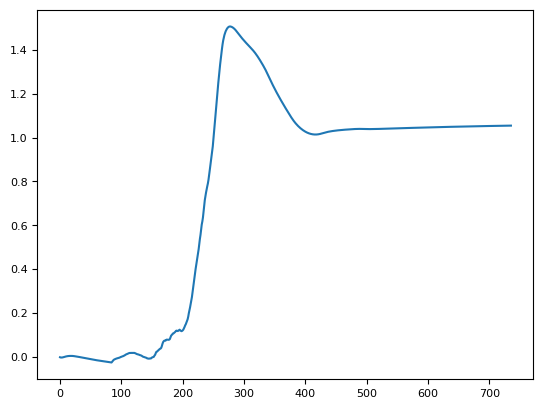

In [ ]:
plt.plot(Tmat[:,2,:,0])

In [ ]:
yr[435]

np.int64(2200)

In [ ]:
import matplotlib as mpl

In [ ]:
sspname

['ssp119', 'ssp245', 'ssp370', 'ssp460', 'ssp534', 'ssp585']

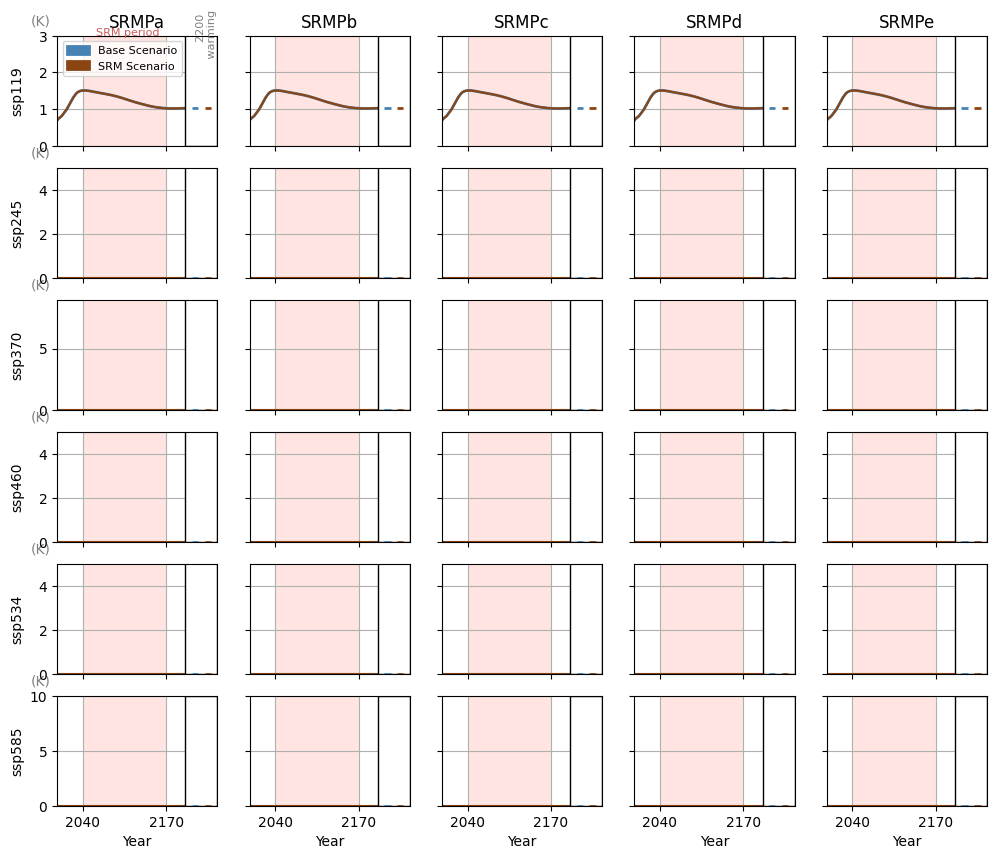

In [ ]:

fig = plt.figure(figsize=(12, 10))

tmax=[3,5,9,5,5,10]
for i,n in reversed(list(enumerate(df.name))):
     for j,ssp in reversed(list(enumerate(ssps))):
 
          ax1 = fig.add_subplot(len(ssps),len(df),j*len(df)+i+1)

          ax1.plot(yr,T0mat[:,i,:,j],':',color='steelblue',label='OS',alpha=0.2)
          ax1.plot(yr,T0mat[:,i,0,j],'-',color='steelblue',label='OS',linewidth=2)
          
          ax1.plot(yr,Tmat[:,i,:,j],color='saddlebrown',label='OS'+df['name'][i]+'-SRM',alpha=0.2)
          ax1.plot(yr,Tmat[:,i,0,j],color='saddlebrown',label='OS'+df['name'][i]+'-SRM')
          
          ax1.set_xticks([2040,2170])

          ax1.set_xlim([1990,2200])


          if j==0:
               if i==0:
                    ax1.text(2060,3,'SRM period',fontsize=8,color='indianred')
                    ax1.text(2250,3,'2200 \n warming',fontsize=8,color='grey',rotation=90,horizontalalignment='right',verticalalignment='center')
          if j==0:
              ax1.set_title(df['name'][i])
          if j==len(ssps)-1:
              ax1.set_xlabel('Year')
          else:
               ax1.set_xticklabels([])

          if i==0:
                ax1.text(-0.25,0.5, sspname[j],  ha="center",va="center",   color='black',  
                    transform=ax1.transAxes,rotation=90)
                ax1.set_ylabel('(K)', color='gray', rotation='horizontal')
                ax1.yaxis.set_label_coords(-0.1,1.2)
                ax1.yaxis.set_label_position('right')
          else:
               
               ax1.set_yticklabels([])

          ax1.set_ylim(0,tmax[j])
     
          ax1.grid()
          ax1.set_xlim([2000,2250])


          data_T0mat = T0mat[435, i, :, j]  # Data for year 2200

          data_Tmat = Tmat[435, i, :, j]    # Data for year 2200
          rb=plt.gca().add_patch(mpl.patches.Rectangle((2200,0) ,50,10,color='w',linestyle='-',linewidth=1,fill=True,zorder=2))
          r1=plt.gca().add_patch(mpl.patches.Rectangle((2210,np.percentile(data_T0mat, 25)) ,10,np.percentile(data_T0mat, 75)-np.percentile(data_T0mat, 25),color='steelblue',linestyle='-',linewidth=2,fill=True,zorder=2))
          r2=plt.gca().add_patch(mpl.patches.Rectangle((2230,np.percentile(data_Tmat, 25)) ,10,np.percentile(data_Tmat, 75)-np.percentile(data_Tmat, 25),color='saddlebrown',linestyle='-',linewidth=2,fill=True,zorder=2))
          rs=plt.gca().add_patch(mpl.patches.Rectangle((2040,0) ,130,10,color='mistyrose',linestyle='none',linewidth=1,fill=True,zorder=1))

          ax1.vlines(2215,np.percentile(data_T0mat, 10) ,np.percentile(data_T0mat, 90),color='steelblue',linestyle='-',linewidth=1)
          ax1.vlines(2235,np.percentile(data_Tmat, 10) ,np.percentile(data_Tmat, 90),color='saddlebrown',linestyle='-',linewidth=1)
          if i+j==0:
               r1l=r1
               r2l=r2
               axl=ax1
          rb.set_edgecolor('k')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)

axl.legend((r1l,r2l),['Base Scenario','SRM Scenario'],loc='upper left', fontsize=8).set_zorder(100)






In [ ]:
r1.set_facecolor('w')

In [ ]:
data_T0mat

array([1.02551725])

 Parameter Set    | `a` (Level Term) | `b` (Rate Term) | `c` (Interaction Term) | `D₀` (Baseline) | Supporting References and Rationale |
|------------------|------------------|-----------------|------------------------|-----------------|-------------------------------------|
| **Conservative** | 0.0023           | 0.001           | 0.01                   | 0.0             | **DICE-2016R** (Nordhaus, 2017) for level damages; minimal rate and interaction terms to align with standard IAM assumptions. |
| **Moderate**     | 0.0028           | 0.005           | 0.025                  | 0.0             | **Lemoine & Traeger (2014)** for rate sensitivity; **Glanemann et al. (2020)** on combined level-rate damages; slightly higher `a` reflecting **Burke et al. (2015)**'s evidence on higher GDP sensitivity to temperature. |
| **High-risk**    | 0.0035           | 0.015           | 0.05                   | 0.0             | **Daniel et al. (2019)** and **Lemoine & Traeger (2014)** on tipping risks and rate-dependence; **precautionary** parameterization to capture high-end damage scenarios and adaptation limits. |

In [ ]:
damage_parameter_sets = {
    "conservative": {"a": 0.0023, "b": 0.00, "c": 0.0, "D0": 0.0},
    "moderate":     {"a": 0.0028, "b": 0.005, "c": 0.025, "D0": 0.0},
    "high-risk":    {"a": 0.0035, "b": 0.015, "c": 0.05, "D0": 0.0},
}



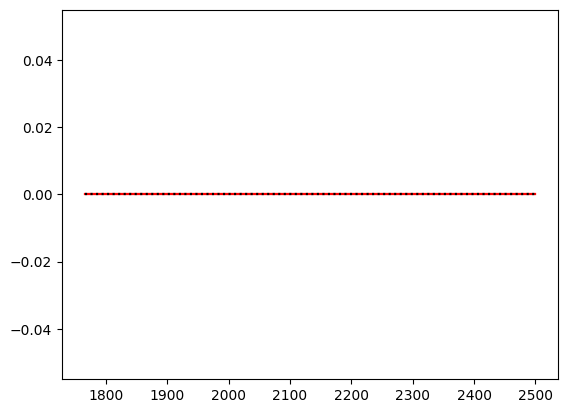

In [ ]:
dmg=calc_damages(Tmat[:,4,:,4],damage_parameter_sets)
dmg0=calc_damages(T0mat[:,4,:,4],damage_parameter_sets)

for key in damage_parameter_sets.keys():
    plt.plot(yr,dmg[key],label=key,color='r')
    plt.plot(yr,dmg0[key],label=key,color='k',linestyle=':')

| Approach                        | Discount Rate Formulation                             | Default Parameter Values                                   | Key References and Rationale                                                |
|---------------------------------|-----------------------------------------------------|-----------------------------------------------------------|------------------------------------------------------------------------------|
| **Standard IAM Assumptions**    | Constant discount rate                             | `ρ = 0.02` (2% per year)                                   | **DICE-2016R** (Nordhaus, 2017); typical in **FUND**, **PAGE**; reflects standard cost-benefit IAM practice.                 |
| **Ethical Alternative (Ramsey)** | Endogenous: `ρ(t) = ρ₀ + η × g`                    | `ρ₀ = 0.001` (0.1% pure time preference), `η = 1.5` (elasticity of marginal utility), `g = 0.015` (1.5% per capita growth) | **Stern Review (2007)** recommends low `ρ₀`; **Lemoine & Traeger (2014)** discuss ethical and precautionary implications; **Pindyck (2012)** on uncertainty and ethics in discounting. |

In [ ]:
import matplotlib as mpl

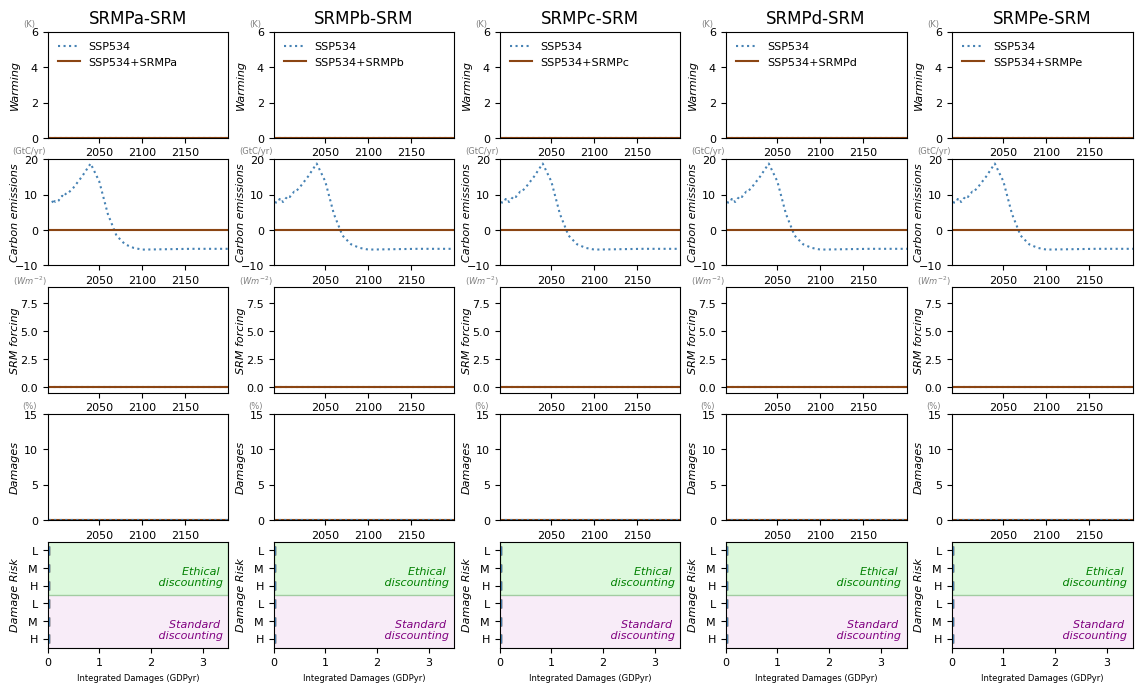

In [ ]:

fig = plt.figure(figsize=(14, 8))
mpl.rc('xtick', labelsize=8) 
mpl.rc('ytick', labelsize=8) 
mpl.rc('axes', labelsize=6)
for i,n in enumerate(df.name):

     ax1 = fig.add_subplot(5,5,i+1)
     ax2 = fig.add_subplot(5,5,i+6)
     ax3 = fig.add_subplot(5,5,i+11)
     ax4 = fig.add_subplot(5,5,i+16)


     
     ax1.plot(yr,T0mat[:,i,0,4],':',color='steelblue',label='SSP534')
     ax1.plot(yr,T0mat[:,i,:,4],':',color='steelblue',alpha=0.2)
     
     
     ax1.plot(yr,Tmat[:,i,0,4],'saddlebrown',label='SSP534+'+df['name'][i])
     ax1.plot(yr,Tmat[:,i,:,4],'saddlebrown',alpha=0.2)

     ax1.set_xlim([1990,2200])
     ax1.set_xticks([2050,2100,2150])
     ax1.set_ylim([0,6])
     ax1.set_title(df['name'][i]+'-SRM')
     ax1.legend(fontsize=8,frameon=False,loc='upper left')
     ax1.set_ylabel('(K)', color='gray', rotation='horizontal')
     ax1.yaxis.set_label_coords(-0.1,1.12)
     ax1.yaxis.set_label_position('right')
     #ax1.text(2010, .5, 'Warming', fontsize=8, style='italic',color='black',horizontalalignment='left')
     ax1.text(-0.18,0.5, "Warming", size=8, ha="center",va="center",   style='italic',color='black',  
         transform=ax1.transAxes,rotation=90)     
     
     ax2.plot(yr,ems_bs,color='steelblue',linestyle=':',label='OS (FF+LU)')
     ax2.plot(yr,demat[:,i,0,4],'saddlebrown',label='Emissions w. SRM effect (FF+LU)')
     ax2.plot(yr,demat[:,i,:,4],'saddlebrown',label='Emissions w. SRM effect (FF+LU)',alpha=0.2)
     ax2.set_xticks([2050,2100,2150])

     #ax2.plot(yr,-gamma*np.diff(T45g0,prepend=0)-beta*np.diff(C45g0,prepend=C34[0,0]),'r',label='land+ocn sink (SSP534-over)')
     #ax2.plot(yr,-gamma*np.diff(Ttmp1s,prepend=0)-beta*np.diff(Ctmp1s,prepend=C34[0,0]),'y',label='land+ocn sink (SSP534-geo)')
     ax2.set_ylabel('(GtC/yr)', color='gray', rotation='horizontal')
     ax2.yaxis.set_label_coords(-0.1,1.12)
     ax2.yaxis.set_label_position('right')
     ax2.text(-0.18,0.5, "Carbon emissions", size=8, ha="center",va="center",   style='italic',color='black',  
         transform=ax2.transAxes,rotation=90)     

     #ax2.legend()

     ax2.set_ylim([-10,20])

     #ax2.plot(yr,ems1s,'y')
     ax2.set_xlim([1990,2200])

     ax3.axhline(0,color='steelblue',linestyle=':')
     ax3.plot(yr,-srmmat[:,i,0,4],'saddlebrown')
     ax3.plot(yr,-srmmat[:,i,:,4],'saddlebrown',alpha=0.2)
     #ax3.plot(frf[i],'r')
     ax3.set_xticks([2050,2100,2150])
     ax3.text(-0.18,0.5, "SRM forcing", size=8, ha="center",va="center",   style='italic',color='black',  
         transform=ax3.transAxes,rotation=90)  
     ax3.set_xlim([1990,2200])

     ax3.set_ylabel('('+r'$Wm^{-2}$)', color='gray', rotation='horizontal')
     ax3.yaxis.set_label_coords(-0.1,1.12)
     ax3.yaxis.set_label_position('right')
     ax3.set_ylim([-.5,9])

     dmg=calc_damages(Tmat[:,i,:,4],damage_parameter_sets)
     dmg0=calc_damages(T0mat[:,i,:,4],damage_parameter_sets)
     ax4.plot(yr,dmg["high-risk"][:,0]*100,color='saddlebrown',label='SSP534+'+df['name'][i])
     ax4.plot(yr,dmg["high-risk"]*100,color='saddlebrown',alpha=0.2)

     ax4.plot(yr,dmg0["high-risk"][:,0]*100,color='steelblue',linestyle=':',label='SSP534')
     ax4.plot(yr,dmg0["high-risk"]*100,color='steelblue',linestyle=':',alpha=0.2)
     ax4.set_xlim([1990,2200])
     ax4.set_xticks([2050,2100,2150])
     #ax4.legend()
     ax4.set_ylim([0,15])
     ax4.set_ylabel('(%)', color='gray', rotation='horizontal')
     ax4.yaxis.set_label_coords(-0.1,1.12)
     ax4.yaxis.set_label_position('right')
     ax4.text(-0.18,0.5, "Damages", size=8, ha="center",va="center",   style='italic',color='black',  
         transform=ax4.transAxes,rotation=90) 
boxprops_srm = dict(linestyle='-', linewidth=0.6, facecolor='lightsalmon', color='saddlebrown',alpha=0.6)
medianprops_srm = dict(linestyle='-.', linewidth=2.5, color='saddlebrown')
meanprops_srm = dict(marker='o', markerfacecolor='saddlebrownk', markeredgecolor='saddlebrown')
whiskerprops_srm = dict(linestyle='-', linewidth=0.6, color='saddlebrown')
capprops_srm = dict(linestyle='-', linewidth=0.6, color='saddlebrown')
flierprops_srm = dict(marker='none', markerfacecolor='saddlebrown', markeredgecolor='saddlebrown')


boxprops = dict(linestyle='-', linewidth=0.6, facecolor='skyblue', color='steelblue',alpha=0.6)
medianprops = dict(linestyle='-.', linewidth=2.5, color='steelblue')
meanprops = dict(marker='o', markerfacecolor='steelblue', markeredgecolor='steelblue')
whiskerprops = dict(linestyle='-', linewidth=0.6, color='steelblue')
capprops = dict(linestyle='-', linewidth=0.6, color='steelblue')
flierprops = dict(marker='none', markerfacecolor='steelblue', markeredgecolor='steelblue')





for i,n in enumerate(df.name):
    ax1 = fig.add_subplot(5,5,i+21)
    dmg=pd.DataFrame(icalc_damages(Tmat[:,i,:,4],damage_parameter_sets))
    dmg0=pd.DataFrame(icalc_damages(T0mat[:,i,:,4],damage_parameter_sets))
    _,p1=dmg.plot.box(vert=False,patch_artist=True,boxprops=boxprops_srm,medianprops=medianprops_srm,capprops=capprops_srm, whiskerprops=whiskerprops_srm,  flierprops=flierprops, return_type='both', ax=ax1, label='SRM')
    _,p2=dmg0.plot.box(vert=False,patch_artist=True,boxprops=boxprops,medianprops=medianprops, capprops=capprops,return_type='both',whiskerprops=whiskerprops, flierprops=flierprops, ax=ax1,label='No SRM')

    #dmg0.boxplot(rot=0,color='k',vert=False,ax=ax1)
    ax1.axhspan(0, 3.5, facecolor='plum', alpha=0.2)
    ax1.axhspan(3.5, 7, facecolor='lightgreen', edgecolor='green',alpha=0.3)
    ax1.set_yticks(range(1,7))
    ax1.set_yticklabels(['H','M','L','H','M','L'])#[x.split('_')[0] for x in list(dmg.columns)],rotation=45)
    #ax1.set_title(df['name'][i]+'-SRM')
    ax1.set_xlim([0,3.5])
    ax1.set_ylim([0.5,6.5])
    ax1.set_xlabel('Integrated Damages (GDPyr)')
    ax1.text(-0.18,0.5, "Damage Risk", size=8, ha="center",va="center",   style='italic',color='black',  
         transform=ax1.transAxes,rotation=90) 
    ax1.text(3.4, 1, 'Standard \n discounting', fontsize=8, style='italic',color='purple',horizontalalignment='right')
    ax1.text(3.4, 4, 'Ethical \n discounting', fontsize=8, style='italic',color='green',horizontalalignment='right')
    #ax1.legend((p1['boxes'][0],p2['boxes'][0]),['SRM','No SRM'],loc='right', bbox_to_anchor=(1., .3))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.2)
#plt.tight_layout()


ValueError: Per-column arrays must each be 1-dimensional

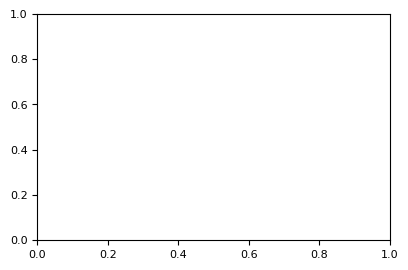

In [ ]:

fig = plt.figure(figsize=(10, 10))
boxprops_srm = dict(linestyle='-', linewidth=0.6, facecolor='lightsalmon', color='saddlebrown',alpha=0.6)
medianprops_srm = dict(linestyle='-.', linewidth=2.5, color='saddlebrown')
meanprops_srm = dict(marker='o', markerfacecolor='saddlebrownk', markeredgecolor='saddlebrown')
whiskerprops_srm = dict(linestyle='-', linewidth=0.6, color='saddlebrown')
capprops_srm = dict(linestyle='-', linewidth=0.6, color='saddlebrown')
flierprops_srm = dict(marker='o', markerfacecolor='saddlebrown', markeredgecolor='saddlebrown')


boxprops = dict(linestyle='-', linewidth=0.6, facecolor='skyblue', color='steelblue',alpha=0.6)
medianprops = dict(linestyle='-.', linewidth=2.5, color='steelblue')
meanprops = dict(marker='o', markerfacecolor='steelblue', markeredgecolor='steelblue')
whiskerprops = dict(linestyle='-', linewidth=0.6, color='steelblue')
capprops = dict(linestyle='-', linewidth=0.6, color='steelblue')
flierprops = dict(marker='o', markerfacecolor='steelblue', markeredgecolor='steelblue')





for i,n in enumerate(df.name):
    ax1 = fig.add_subplot(3,2,i+1)
    dmg=pd.DataFrame(icalc_damages(Tmat[:,i,:],damage_parameter_sets))
    dmg0=pd.DataFrame(icalc_damages(T0mat[:,i,:],damage_parameter_sets))
    _,p1=dmg.plot.box(vert=False,patch_artist=True,boxprops=boxprops_srm,medianprops=medianprops_srm,capprops=capprops_srm, whiskerprops=whiskerprops_srm,   return_type='both', ax=ax1, label='SRM')
    _,p2=dmg0.plot.box(vert=False,patch_artist=True,boxprops=boxprops,medianprops=medianprops, capprops=capprops,return_type='both',whiskerprops=whiskerprops, ax=ax1,label='No SRM')

    #dmg0.boxplot(rot=0,color='k',vert=False,ax=ax1)
    ax1.axhspan(0, 3.5, facecolor='plum', alpha=0.2)
    ax1.axhspan(3.5, 7, facecolor='lightgreen', edgecolor='green',alpha=0.3)
    ax1.set_yticks(range(1,7))
    ax1.set_yticklabels([x.split('_')[0] for x in list(dmg.columns)])
    ax1.set_title(df['name'][i]+'-SRM')
    ax1.set_xlim([0,3.5])
    ax1.set_ylim([0.5,6.5])
    ax1.set_xlabel('Damage (fGDP)')
    ax1.text(3.4, 1, 'Standard discounting', fontsize=10, style='italic',color='purple',horizontalalignment='right')
    ax1.text(3.4, 4, 'Ethical discounting', fontsize=10, style='italic',color='green',horizontalalignment='right')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.45, hspace=0.35)
ax1.legend((p1['boxes'][0],p2['boxes'][0]),['SRM','No SRM'],loc='upper right', bbox_to_anchor=(1.5, 0.6))




In [ ]:
p1['boxes'][0]

In [ ]:
[x.split('_')[0] for x in list(dmg.columns)]

['conservative',
 'moderate',
 'high-risk',
 'conservative',
 'moderate',
 'high-risk']

In [ ]:
patch

NameError: name 'patch' is not defined

In [ ]:
patch

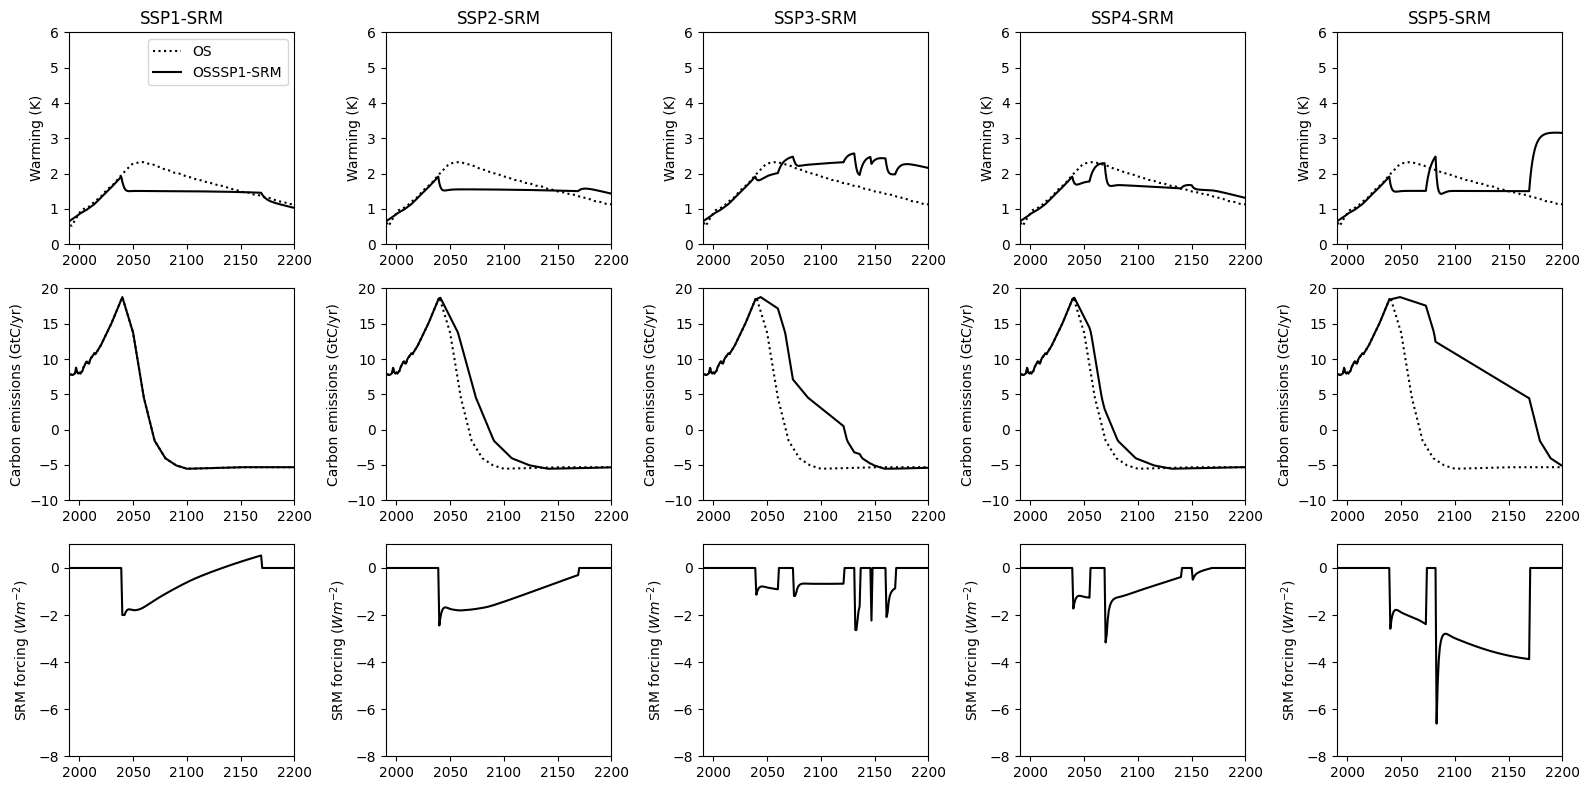

In [ ]:

fig = plt.figure(figsize=(16, 8))

for i,n in enumerate(df.name):

     ax1 = fig.add_subplot(3,5,i+1)
     ax2 = fig.add_subplot(3,5,i+6)
     ax3 = fig.add_subplot(3,5,i+11)
     ax1.plot(yr,T34,'k:',label='OS')
     ax1.plot(yr,Ttmp1s[:,i],'k',label='OS'+df['name'][i]+'-SRM')
     ax1.set_xlim([1990,2200])
     ax1.set_ylim([0,6])
     ax1.set_title(df['name'][i]+'-SRM')
     if i==0:
          ax1.legend()
     ax1.set_ylabel('Warming (K)')

     ax2.plot(yr,ems_bs,'k:',label='OS (FF+LU)')
     ax2.plot(yr,de[:,i],'k',label='Emissions w. SRM effect (FF+LU)')

     #ax2.plot(yr,-gamma*np.diff(T45g0,prepend=0)-beta*np.diff(C45g0,prepend=C34[0,0]),'r',label='land+ocn sink (SSP534-over)')
     #ax2.plot(yr,-gamma*np.diff(Ttmp1s,prepend=0)-beta*np.diff(Ctmp1s,prepend=C34[0,0]),'y',label='land+ocn sink (SSP534-geo)')
     ax2.set_ylabel('Carbon emissions (GtC/yr)')

     #ax2.legend()

     ax2.set_ylim([-10,20])

     #ax2.plot(yr,ems1s,'y')
     ax2.set_xlim([1990,2200])

     ax3.plot(yr,srm1s[:,i],'k')
     #ax3.plot(frf[i],'r')
     
     ax3.set_xlim([1990,2200])

     ax3.set_ylabel('SRM forcing ('+r'$Wm^{-2}$)')
     ax3.set_ylim([-8,1])



plt.tight_layout()


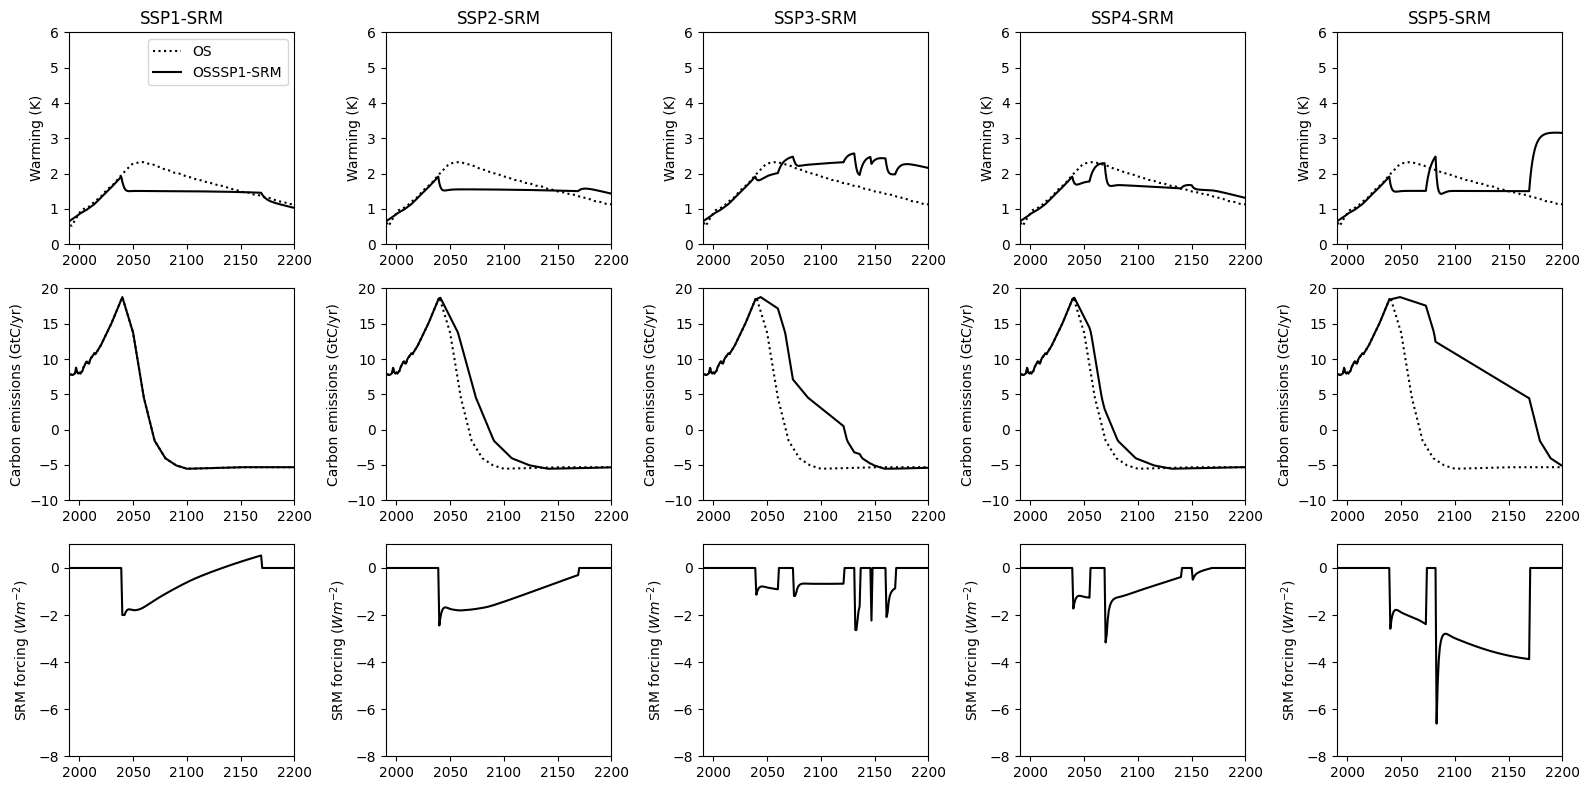

In [ ]:

fig = plt.figure(figsize=(16, 8))

for i,n in enumerate(df.name):

     ax1 = fig.add_subplot(3,5,i+1)
     ax2 = fig.add_subplot(3,5,i+6)
     ax3 = fig.add_subplot(3,5,i+11)
     ax1.plot(yr,T34,'k:',label='OS')
     ax1.plot(yr,Ttmp1s[:,i],'k',label='OS'+df['name'][i]+'-SRM')
     ax1.set_xlim([1990,2200])
     ax1.set_ylim([0,6])
     ax1.set_title(df['name'][i]+'-SRM')
     if i==0:
          ax1.legend()
     ax1.set_ylabel('Warming (K)')

     ax2.plot(yr,ems_bs,'k:',label='OS (FF+LU)')
     ax2.plot(yr,de[:,i],'k',label='Emissions w. SRM effect (FF+LU)')

     #ax2.plot(yr,-gamma*np.diff(T45g0,prepend=0)-beta*np.diff(C45g0,prepend=C34[0,0]),'r',label='land+ocn sink (SSP534-over)')
     #ax2.plot(yr,-gamma*np.diff(Ttmp1s,prepend=0)-beta*np.diff(Ctmp1s,prepend=C34[0,0]),'y',label='land+ocn sink (SSP534-geo)')
     ax2.set_ylabel('Carbon emissions (GtC/yr)')

     #ax2.legend()

     ax2.set_ylim([-10,20])

     #ax2.plot(yr,ems1s,'y')
     ax2.set_xlim([1990,2200])

     ax3.plot(yr,srm1s[:,i],'k')
     #ax3.plot(frf[i],'r')
     
     ax3.set_xlim([1990,2200])

     ax3.set_ylabel('SRM forcing ('+r'$Wm^{-2}$)')
     ax3.set_ylim([-8,1])



plt.tight_layout()
